In [1]:
# -*- coding: uft-8 -*-

# Réalisez une application de recommandation de contenu
***

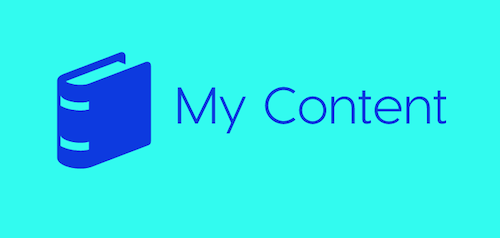

# Mission
### `Future Vision Transport` est une start-up qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs.
### Pour ce faire, nous allons construire un MVP(Minimum Viable Product) sous la forme d'une application qui va recommender une sélection de 5 article pour 1 utilisateur.
### Nous nous baserons sur le jeu de données fourni par Globo.com représentant les interactions des utilisateurs avec les articles et contenant des informations telles que :
#### &emsp; 1/Articles, ie: Le nombre de mots dans l’article
#### &emsp; 2/Sessions utilisateur, ie : L'heure de début et de fin d'une session
#### &emsp; 3/Interactions utilisateur-article, ie: Les articles consultés lors d'une session utilisateur

### A noter que l’ajout de nouveaux utilisateurs et de nouveaux articles dans l’architecture cible de l'application(MVP) sera déterminante.

<a class="anchor" id="sommaire"></a>

### Table des matières

* [1/ Gestion des données](#chapitre1)
    * [1.1/ Import des bibliothèques python et des données](#partie_1_1)
    * [1.2/ Gestion des données](#partie_1_2)
        * [1.2.1/ Récupération des données](#partie_1_2_1)
        * [1.2.2/ Analyse des données et suppressions des outliers](#partie_1_2_2)
* [2/ Les différentes approches](#chapitre2)
    * [2.1/ Content Based Filtering](#partie_2_1)
        * [2.1.1/ Préparation des données](#partie_2_1_1)
        * [2.1.2/ Calcul de la similarité du cosinus](#partie_2_1_2)
        * [2.1.3/ Recommandations](#partie_2_1_3)
    * [2.2/ Collaborative filtering](#partie_2_2)
        * [2.2.1/ Préparation des données](#partie_2_2_1)
        * [2.2.2/ Calcul de la similarité du cosinus](#partie_2_2_2)
        * [2.2.3/ Recommandations](#partie_2_2_3)
* [3/ Recommandations classées par ordre de similarité (mix des 2 approches)](#chapitre3)
    * [3.1/ Principe](#partie_3_1)
    * [3.2/ Calcul et sauvegarde pour future application](#partie_3_2)
    
* [4/ Bonus : modèle externe via la librairie Surprise](#chapitre4)
    * [4.1/ Préparation des données](#partie_4_1)
    * [4.2/ Modèles et entrainements](#partie_4_2)
    * [4.3/ Prédictions](#partie_4_3)

In [2]:
# Install conda/pip packages in the current Jupyter kernel
import sys


'''
# A DECOMMENTER POUR RE-INSTALLER "FROM SCRATCH"

!conda install --yes --prefix {sys.prefix} seaborn
!{sys.executable} -m pip install pandas
!conda install --yes --prefix {sys.prefix} -c conda-forge ipywidgets
!{sys.executable} -m pip install tqdm


# scikit-learn
!{sys.executable} -m pip install scikit-learn

# Web Application
!{sys.executable} -m pip install streamlit==1.15.2


# Surprise #NOT USED
#!conda install --yes --prefix {sys.prefix} -c conda-forge scikit-surprise


#Azure
!{sys.executable} -m pip install azure-core



#APPLICATION and API
#!conda install --yes --prefix {sys.prefix} flask=2.0.3
!{sys.executable} -m pip install werkzeug==2.0.3
!{sys.executable} -m pip install flask==2.0.3
#!conda install --yes --prefix {sys.prefix} streamlit
#!conda install --yes --prefix {sys.prefix} -c conda-forge streamlit
!{sys.executable} -m pip install streamlit==1.15.2

''';

<a class="anchor" id="chapitre1"></a><hr><center><b><h1><font color=orange>1/ Gestion des données</font></h1></b></center><hr>

<a class="anchor" id="partie_1_1"></a><b><h2><font color=purple>1.1/ Import des bibliothèques python et des données</font></h2></b>

In [118]:
from __future__ import print_function

# Manipulation de données
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Utilaires
import re
import os
import glob

#from collections import Counter, namedtuple
#import logging
import time
import pickle
import shutil
from tqdm import tqdm

# My functions
#import Guitarian_Guillaume_0_myFunctions_012023 as mfs 


#Cosin similarity
from sklearn.metrics.pairwise import cosine_similarity

# Normalisation
from sklearn.preprocessing import MinMaxScaler

#Surprise
from surprise import SVD, accuracy
from surprise import Dataset
from surprise import Reader
from surprise.builtin_datasets import BUILTIN_DATASETS, download_builtin_dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms.knns import KNNBasic


from collections import defaultdict


%matplotlib inline
sns.set() 

***
# Configuration Globale

In [4]:
#Détectons pour chacune de nos variable quantitative, les bornes MIN (Q1 - 1,5 IQR) et MAX (Q3 + 1,5 IQR) avec IQR = Q3-Q1
def getOutliers(var_list, dataFrame, coef=1.5):
    """
    Parcours une liste de colonnes de dataframe dans le
    but de définir les valeurs min et max considérées 
    comme NON aberrantes    

    Args:
        var_list: list of dataframe columns (quantitative var)
        dataFrame: the dataframe in which the quantitative var are

    Returns:
        bornes: dictionnary of the limits (min and max) for each var in var_list
    """
    bornes = {}
    for var_name in var_list:
        var = dataFrame[var_name]
        Q1 = var.quantile(0.25)
        Q3 = var.quantile(0.75)
        IQR = Q3-Q1
        maxVal = Q3 + coef * IQR
        minVal = Q1 - coef * IQR
        bornes[var_name] = [minVal, maxVal]
    return bornes

In [5]:
def cleanOutliers(var_list, dataFrame, outliersDic):
    """
    Parcours une liste de colonnes de dataframe dans le
    but de filtrer ce dernier    

    Args:
        var_list: list of dataframe columns (quantitative var)
        dataFrame: the dataframe in which the quantitative var are
        outliersDic: dictionnary of outliers

    Returns:
        dataFrame: the filtered dataframe
    """
    for var_name in var_list:
        dataFrame = dataFrame[(dataFrame[var_name] >= outliersDic[var_name][0]) & (dataFrame[var_name] <= outliersDic[var_name][1])]
    return dataFrame

In [6]:
#tf.config.list_physical_devices()

<a class="anchor" id="partie_1_2"></a><b><h2><font color=purple>1.2/ Gestion des données</font></h2></b>

### Nous allons utiliser le jeux de données décrit ici : <a href="https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom/">Globo.com</a>

<a class="anchor" id="partie_1_2_1"></a><b><h3><font color=blue>1.2.1/ Récupération des données</font></h3></b>

## Il y a 3 fichiers : 

### &emsp;- `articles_embeddings.pickle` contenant les embeddings des articles
### &emsp;- `articles_metadata.csv` contenant des donées articles 
### &emsp;- `clicks.zip` contenant les sessions de lecture d'articles des utilisateurs et dont un aperçu est donné via le fichier `clicks_sample.csv`

### Déplacement des images depuis les jeux d'images et masques d'origines vers une arborescence plus pratique

In [7]:
# répertoire courant, ne se termine PAS par un séparateur
current_path = os.path.abspath(os.getcwd())
# Séparateur de chemin d'accès en fonction de l'os
path_sep = os.path.sep

In [8]:
current_path

'C:\\Users\\conra\\MesNoteBooks\\P9'

In [9]:
clicks_sample = pd.read_csv('clicks_sample.csv', encoding='utf-8'
                                         , low_memory=True
                                         , index_col=False)
articles_metadata = pd.read_csv('articles_metadata.csv', encoding='utf-8'
                                         , low_memory=True
                                         , index_col=False)
articles_embedding = pd.read_pickle('articles_embeddings.pickle')

In [10]:
print("taille de : \n" \
F"clicks = {clicks_sample.shape} \n" \
F"articles_metadata = {articles_metadata.shape} \n" \
F"articles_embedding = {articles_embedding.shape} "
)

taille de : 
clicks = (1883, 12) 
articles_metadata = (364047, 5) 
articles_embedding = (364047, 250) 


In [11]:
clicks_sample.head(3)

user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   
1    1506826858020                  4                  3        20   
2    1506827017951                  4                  1        17   

   click_country  click_region  click_referrer_type  
0              1            20                    2  
1              1            20                    2  
2              1            16                    2

In [12]:
articles_metadata.head(3)

article_id  category_id  created_at_ts  publisher_id  words_count
0           0            0  1513144419000             0          168
1           1            1  1405341936000             0          189
2           2            1  1408667706000             0          250

In [13]:
print(articles_embedding)

[[-0.16118301 -0.95723313 -0.13794445 ... -0.231686    0.5974159
   0.40962312]
 [-0.52321565 -0.974058    0.73860806 ...  0.18282819  0.39708954
  -0.83436364]
 [-0.61961854 -0.9729604  -0.20736018 ... -0.44758022  0.8059317
  -0.28528407]
 ...
 [-0.25139043 -0.9762427   0.58609664 ... -0.14372464  0.06809307
  -0.7050104 ]
 [ 0.22434181 -0.92328775 -0.38174152 ...  0.6871319  -0.5315117
   0.01072566]
 [-0.25713393 -0.9946313   0.9837918  ...  0.98387307 -0.8381829
  -0.1792827 ]]


### Récupérons l'ensemble des fichiers `clicks_hour_XXX.csv` dans 1 seul dataframe

In [14]:
# merging the files
files_joined = os.path.join(current_path + path_sep + 'clicks', "clicks_hour_*.csv")

# Return a list of all joined files
list_files = glob.glob(files_joined)

print("** Merging multiple csv files into a single pandas dataframe **")
# Merge files by joining all files
clicks = pd.concat(map(pd.read_csv, list_files), ignore_index=True)
print(F"clicks = {clicks.shape}")

** Merging multiple csv files into a single pandas dataframe **
clicks = (2988181, 12)


### Nous constatons qu'il y a donc presque 3 millions d'entrées dans les sessions de lecture.

In [15]:
clicks.describe() 

user_id        session_id  session_start  session_size  \
count   2988181           2988181        2988181       2988181   
unique   322897           1048594         646874            72   
top        5890  1507563657895091  1507563657000             2   
freq       1232               124            127       1260372   

        click_article_id  click_timestamp  click_environment  \
count            2988181          2988181            2988181   
unique             46033          2983198                  3   
top               160974    1506961009961                  4   
freq               37213                3            2904478   

        click_deviceGroup  click_os  click_country  click_region  \
count             2988181   2988181        2988181       2988181   
unique                  5         8             11            28   
top                     1        17              1            25   
freq              1823162   1738138        2852406        804985   

        click_referrer_type  
count               2988181  
unique                    7  
top                       2  
freq                1602601

***
<a class="anchor" id="partie_1_2_2"></a><b><h3><font color=blue>1.2.2/ Analyse des données et suppressions des outliers</font></h3></b>

### Le dataframe des sessions de lecture contient presque 3 Millions d'entrées et plus particulièrement, il n'y a que 322897 utilisateurs (uniques) et `seulement` 46033 articles lus sur les 364047 articles existants dans `articles_embedding` 
***
## Les articles qui n'ont pas du tout été lus pourrais nous être utiles (`uniquement` pour le content based filtering), mais pour des questions de volumétrie et temps de calcul, nous allons devoir nous en séparer !

In [16]:
# On transforme articles_embedding en dataframe pour pouvoir le filtrer plus facilement
articles_embedding_df = pd.DataFrame(articles_embedding)
articles_embedding_df

0         1         2         3         4         5         6    \
0      -0.161183 -0.957233 -0.137944  0.050855  0.830055  0.901365 -0.335148   
1      -0.523216 -0.974058  0.738608  0.155234  0.626294  0.485297 -0.715657   
2      -0.619619 -0.972960 -0.207360 -0.128861  0.044748 -0.387535 -0.730477   
3      -0.740843 -0.975749  0.391698  0.641738 -0.268645  0.191745 -0.825593   
4      -0.279052 -0.972315  0.685374  0.113056  0.238315  0.271913 -0.568816   
...          ...       ...       ...       ...       ...       ...       ...   
364042 -0.055038 -0.962136  0.869436 -0.071523 -0.725294  0.434320  0.198312   
364043 -0.136932 -0.995471  0.991298  0.031871 -0.915622 -0.658517  0.633090   
364044 -0.251390 -0.976243  0.586097  0.643631 -0.663359 -0.093480  0.691553   
364045  0.224342 -0.923288 -0.381742  0.687890 -0.773911 -0.103629 -0.406486   
364046 -0.257134 -0.994631  0.983792 -0.190975 -0.953720 -0.893823  0.708974   

             7         8         9    ...       240       241       242  \
0      -0.559561 -0.500603  0.165183  ...  0.321248  0.313999  0.636412   
1      -0.897996 -0.359747  0.398246  ... -0.487843  0.823124  0.412688   
2      -0.066126 -0.754899 -0.242004  ...  0.454756  0.473184  0.377866   
3      -0.710591 -0.040099 -0.110514  ...  0.271535  0.036040  0.480029   
4       0.341194 -0.600554 -0.125644  ...  0.238286  0.809268  0.427521   
...          ...       ...       ...  ...       ...       ...       ...   
364042 -0.581154  0.702346 -0.124813  ... -0.410549  0.564252 -0.463959   
364043 -0.564356  0.676551 -0.446068  ... -0.681986 -0.574185 -0.536908   
364044 -0.588281  0.902999  0.124571  ... -0.162220 -0.242030 -0.476131   
364045  0.246004  0.255191 -0.329587  ... -0.422999  0.390324  0.655911   
364046 -0.557027  0.846842 -0.118519  ... -0.490481 -0.689666 -0.661846   

             243       244       245       246       247       248       249  
0       0.169179  0.540524 -0.813182  0.286870 -0.231686  0.597416  0.409623  
1      -0.338654  0.320787  0.588643 -0.594137  0.182828  0.397090 -0.834364  
2      -0.863887 -0.383365  0.137721 -0.810877 -0.447580  0.805932 -0.285284  
3      -0.763173  0.022627  0.565165 -0.910286 -0.537838  0.243541 -0.885329  
4      -0.615932 -0.503697  0.614450 -0.917760 -0.424061  0.185484 -0.580292  
...          ...       ...       ...       ...       ...       ...       ...  
364042  0.167907 -0.480068  0.652090  0.380880  0.433195 -0.662455 -0.222850  
364043  0.688934  0.528204  0.162435  0.940364  0.989298 -0.761595 -0.414652  
364044  0.352132 -0.311279  0.460574 -0.653077 -0.143725  0.068093 -0.705010  
364045 -0.646753 -0.174031  0.698037 -0.317102  0.687132 -0.531512  0.010726  
364046  0.490945  0.736525  0.667668  0.902130  0.983873 -0.838183 -0.179283  

[364047 rows x 250 columns]

### Aussi `articles_metadata` nous a permis de voir que la `clef "article_id"` commence bien à **0** ce qui nous confirme que les index de notre dataframe `articles_embedding_df` correspondent bien du coup aux `article_id` 
### Nous pouvons également remarquer que le nombre de colonnes s'élève bien à `250` ce qui est la taille d'un vecteur d'embedding d'article

In [17]:
# On récupère la liste ids d'articles qui ont été lus
article_ids_lus=clicks['click_article_id'].sort_values(ascending=True).unique().tolist()

articles_embedding_df=articles_embedding_df[articles_embedding_df.index.isin(article_ids_lus)]

In [18]:
print(F"Nous avons bien {articles_embedding_df.shape[0]} articles dans le dataframe 'articles_embedding_df'") 

Nous avons bien 46033 articles dans le dataframe 'articles_embedding_df'


***
# Nous pouvons plus généralement examiner le nombre (absolu) de lecture par article afin d'en retirer d'éventuelles valeurs aberrantes

In [19]:
nb_lecture_par_article = clicks.groupby(by=['click_article_id']).agg({
    'user_id': 'count',
}).rename(columns={"user_id": "readings_qty"}).reset_index()

nb_lecture_par_article

click_article_id  readings_qty
0                     3             1
1                    27             1
2                    69             1
3                    81             2
4                    84             1
...                 ...           ...
46028            364017            22
46029            364022             1
46030            364028             1
46031            364043             8
46032            364046             2

[46033 rows x 2 columns]

In [20]:
nb_lecture_par_article_graph = nb_lecture_par_article.sort_values(by='readings_qty', ascending=True).reset_index()
nb_lecture_par_article_graph

index  click_article_id  readings_qty
0          0                 3             1
1      17437            120371             1
2      17436            120365             1
3      17435            120361             1
4      17434            120347             1
...      ...               ...           ...
46028  17796            123909         23122
46029  31179            234698         23499
46030  43107            336221         23851
46031  35378            272143         28943
46032  21952            160974         37213

[46033 rows x 3 columns]

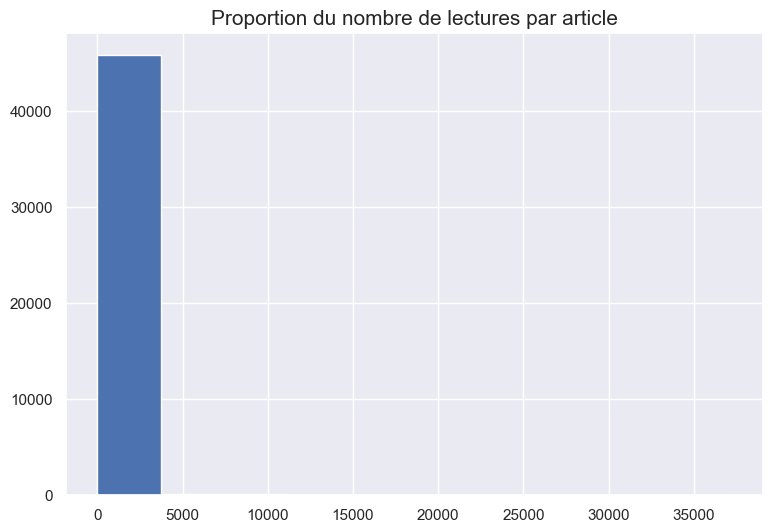

In [21]:
plt.figure(figsize=(9,6))
nb_lecture_par_article_graph["readings_qty"].plot.hist()
plt.title("Proportion du nombre de lectures par article", fontsize=15)
plt.ylabel("")
plt.show()

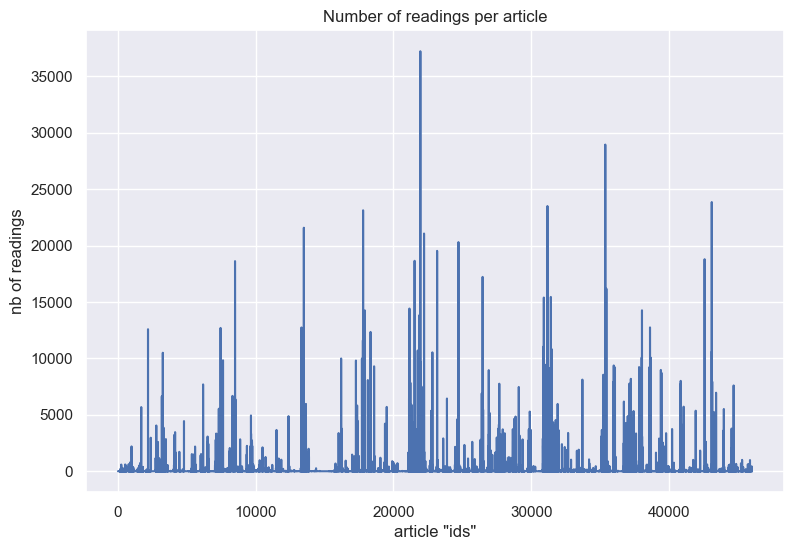

In [22]:
nb_lecture_par_article.plot(
    y='readings_qty', 
    figsize=(9,6), 
    xlabel ='article "ids"', 
    ylabel ='nb of readings',
    title  ='Number of readings per article',
    legend = False
);

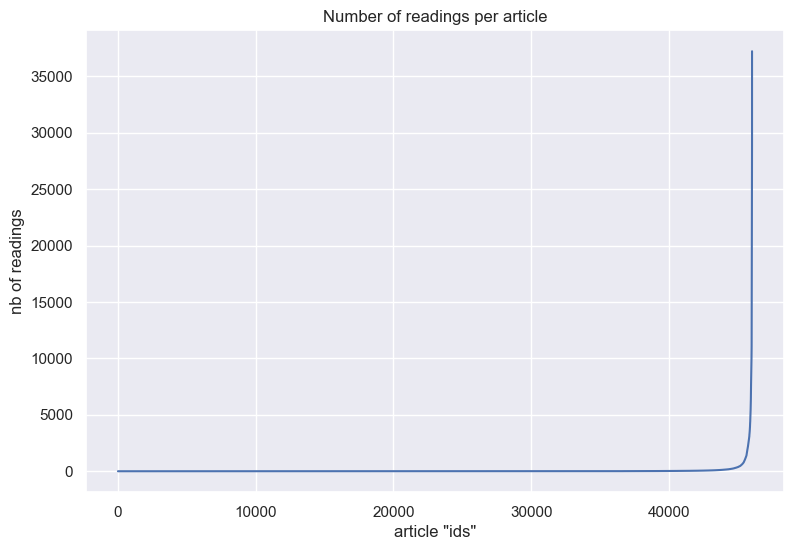

In [23]:
nb_lecture_par_article_graph.plot(
    y='readings_qty', 
    figsize=(9,6), 
    xlabel ='article "ids"', 
    ylabel ='nb of readings',
    title  ='Number of readings per article',
    legend = False
);

***
### Visualisons le nombre de lecture par article de plus près

In [24]:
nb_lecture_par_article.describe()

click_article_id  readings_qty
count      46033.000000  46033.000000
mean      173974.753286     64.913888
std       103198.968039    629.322888
min            3.000000      1.000000
25%        83525.000000      1.000000
50%       167166.000000      1.000000
75%       264671.000000      6.000000
max       364046.000000  37213.000000

### La médiane est à 1 lecture par article, poussons l'analyse

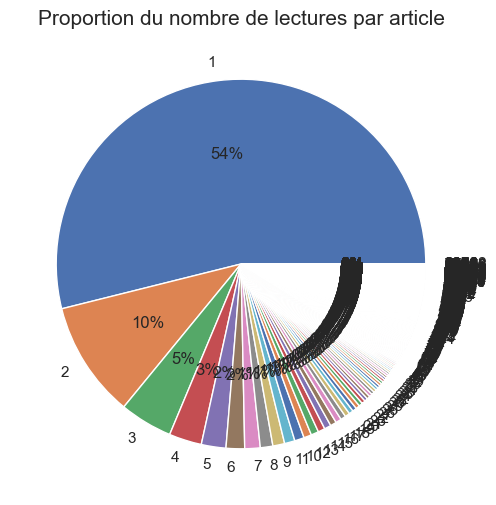

In [25]:
plt.figure(figsize=(9,6))
nb_lecture_par_article["readings_qty"].value_counts().plot.pie(autopct="%1.0f%%")
plt.title("Proportion du nombre de lectures par article", fontsize=15)
plt.ylabel("")
plt.show()

### Nous pouvoir voir qu'il y comme une prépondérance de lecture `unique` d'article, le problème va se poser pour le `collaborative filtering` ou pour faire des recommendations nous avons besoin d'articles qui ont été lu plus d'une fois (par plusieurs utilisateur donc)

***
## Mais qu'en est-il du nombre de lectures par utilisateur ? Existe-il des utilisateurs qui n'ont lu qu' 1 seul article ???

In [26]:
nb_lecture_par_utilisateur = clicks.groupby(by=['user_id']).agg({
    'click_article_id': 'count',
}).rename(columns={"click_article_id": "article_qty"}).reset_index()

nb_lecture_par_utilisateur

user_id  article_qty
0             0            8
1             1           12
2             2            4
3             3           17
4             4            7
...         ...          ...
322892   322892            2
322893   322893            2
322894   322894            2
322895   322895            2
322896   322896            2

[322897 rows x 2 columns]

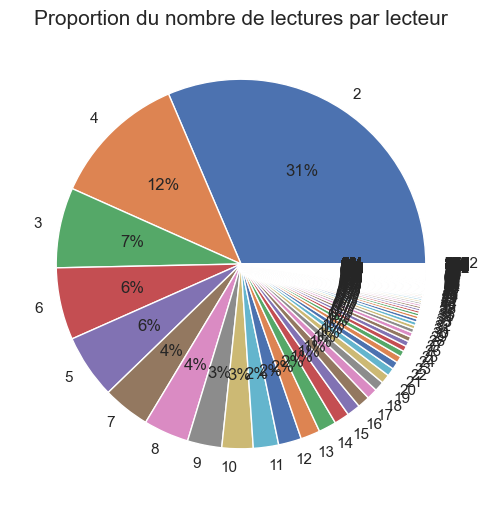

In [27]:
plt.figure(figsize=(9,6))
nb_lecture_par_utilisateur["article_qty"].value_counts().plot.pie(autopct="%1.0f%%")
plt.title("Proportion du nombre de lectures par lecteur", fontsize=15)
plt.ylabel("")
plt.show()

## La réponse ici visible est qu'aucun utilisateur n'a lu qu'1 seul article, cela signifie que si nous commencions par "traiter" les utilisateur notamment en supprimant les valeurs aberrantes et que nous "traitions" de la même manière les articles mais qu'en plus nous supprimions les articles qui n'ont été lus qu'1 seul fois, et bien en fin de traitement nous allons nous retrouver avec un jeux de données où nous aurons bien des utilisateurs ayant lu qu'1 seul article alors que l'on en avait pas avant tout traitement. 

## En effet, concernant les articles lus qu'1 seule fois, existent des utilisateurs qui n'ont lu que 2 articles dont 1 qui n'a été lu que par cet utilisateur et si l'on supprime cet article, l'utilisateur en question se retrouvera avec 1 seule lecture à son actif ce que nous ne souhaitons pas. 

## Il faut donc commencer par traiter les articles et ensuite les utilisateurs !

# Une autre solution serait de traiter les articles et les users séparément, l'un pour le content base filtering et l'autre pour le collaborative filtering...

***
## Commençons donc par traiter les articles

### Pour la même raison qu'évoqué plus tôt, nous allons nous séparer des articles qui n'ont pas au moins été lus 5 fois ou plus, cela va nous permettre de conserver environ 28% des articles les plus qualitatifs (au moins pour le collaborative filtering)

In [28]:
article_id_5_or_more_readden = nb_lecture_par_article[nb_lecture_par_article['readings_qty'] >=5].click_article_id.tolist()
nb_lecture_par_article=nb_lecture_par_article[nb_lecture_par_article['click_article_id'].isin(article_id_5_or_more_readden)]
nb_lecture_par_article

click_article_id  readings_qty
119                1779             8
121                1799             6
123                1843            11
124                1844            13
125                1873            30
...                 ...           ...
46014            363967            79
46016            363976            43
46020            363984            12
46028            364017            22
46031            364043             8

[13096 rows x 2 columns]

### Mais comme nous pouvons le voir ci-dessous, ils restent tout de même des valeurs aberrantes bien au dessus du 75 percentile

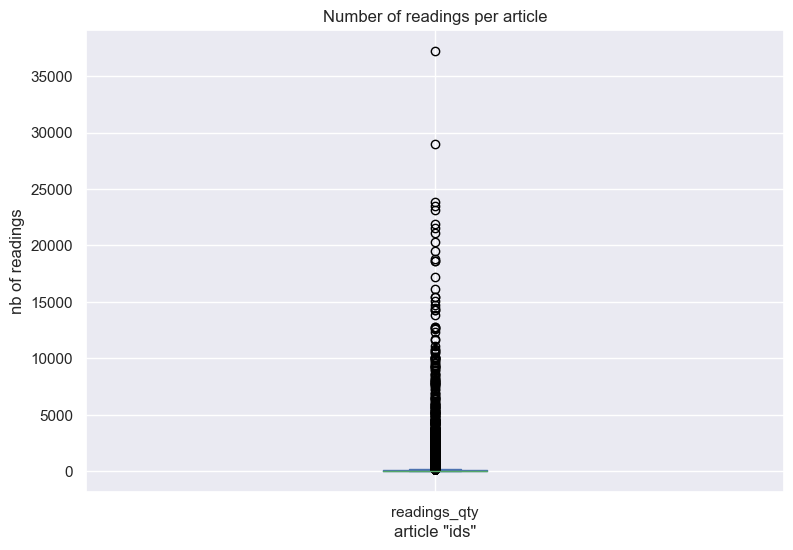

In [29]:
nb_lecture_par_article.plot(
    kind='box',
    y='readings_qty', 
    figsize=(9,6), 
    xlabel ='article "ids"', 
    ylabel ='nb of readings',
    title  ='Number of readings per article',
    legend = False
);

### Le nombre de valeurs aberrantes est tellement grand qu'il est difficile de visualiser la boite à moustache (boxplot) !

In [30]:
nb_lecture_par_article.describe()

click_article_id  readings_qty
count      13096.000000  13096.000000
mean      181388.621640    224.676161
std       104460.940841   1164.698454
min         1779.000000      5.000000
25%        87192.750000      9.000000
50%       182403.500000     22.000000
75%       273224.250000     67.000000
max       364043.000000  37213.000000

### Nous constatons que certains articlesont été lus 37000 fois avec une moyenne de lectures par article à environ 224, nous devons nous séparer de ces cas extrêmes.

### A noté que la `médiane` est à 22 lectures par article

### Pour ce faire, considérons comme on peut le voir ici : https://ichi.pro/fr/preparation-des-donnees-partie-2-valeurs-aberrantes-79516046564575 , pour une variable donnée, toute valeur comme aberrante si elle dépasse la valeur `Q3 + 1,5 * IQR` OU si elle inférieure à `Q1 - 1,5 * IQR`, avec `Q3` le 75ème centile de données, `Q1` le 25ème centile de données et `IQR` la valeur interquartile `Q3-Q1`

In [31]:
filtering_var_list = ['readings_qty']
bornes_dic = getOutliers(filtering_var_list, nb_lecture_par_article)
bornes_dic

{'readings_qty': [-78.0, 154.0]}

In [32]:
# Le nombre d'article lu ne pouvant être inférieur à 0
# pour une question de commodité, nous pouvons changer
# la borne inférieure
bornes_dic['readings_qty'][0] = 0

In [33]:
nb_lecture_par_article_filtered = cleanOutliers(filtering_var_list, nb_lecture_par_article, bornes_dic)

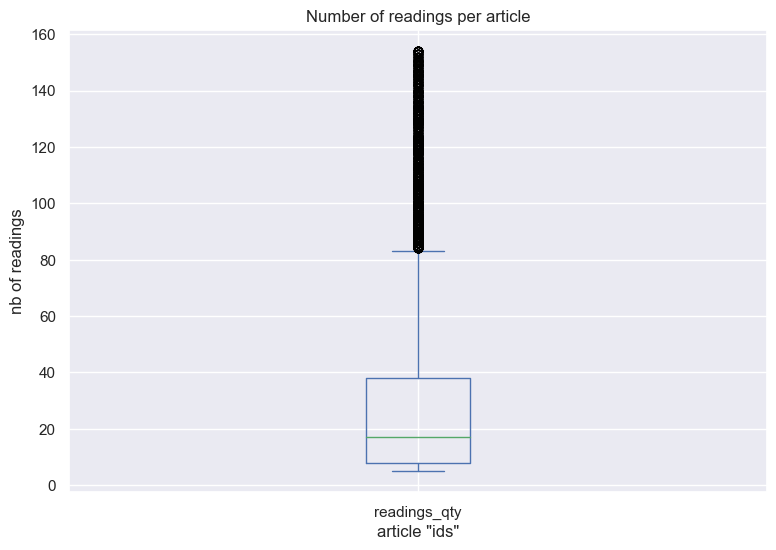

In [34]:
nb_lecture_par_article_filtered.plot(
    kind='box',
    y='readings_qty', 
    figsize=(9,6), 
    xlabel ='article "ids"', 
    ylabel ='nb of readings',
    title  ='Number of readings per article',
    legend = False
);

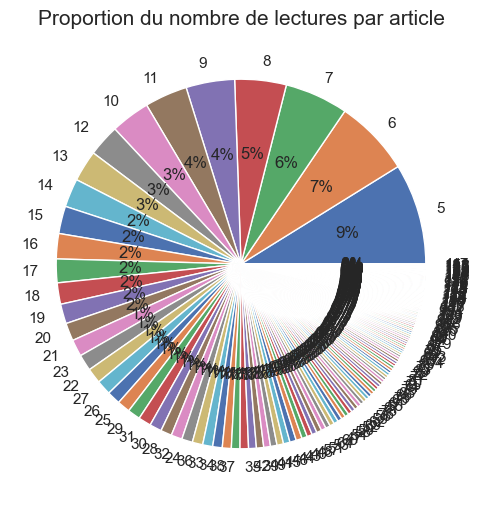

In [35]:
plt.figure(figsize=(9,6))
nb_lecture_par_article_filtered["readings_qty"].value_counts().plot.pie(autopct="%1.0f%%")
plt.title("Proportion du nombre de lectures par article", fontsize=15)
plt.ylabel("")
plt.show()

In [36]:
nb_lecture_par_article_filtered.describe()

click_article_id  readings_qty
count      11198.000000  11198.000000
mean      180922.499643     29.665208
std       106458.310706     31.394720
min         1779.000000      5.000000
25%        84539.750000      8.000000
50%       181851.500000     17.000000
75%       276742.500000     38.000000
max       364043.000000    154.000000

### A noté que la `médiane` est passé à 17 lecture par article, notre suppression des valeurs extrêmes s'est relativement bien déroulée.

### Nous n'avons donc plus que 11198 articles sur les 46033 initiaux et que les `outliers` ont bien été supprimés et nous nous retrouvons avec une moyenne de lectures par article qui passe de plus de 224 à environ 30.
***
### Il nous faut à présent filtrer le dataframe d'origine, `clicks`, sur les 11198 `click_article_id` restants

In [37]:
article_ids_to_keep = nb_lecture_par_article_filtered['click_article_id'].tolist()
clicks=clicks[clicks['click_article_id'].isin(article_ids_to_keep)]
clicks.describe()

user_id        session_id  session_start  session_size  \
count    332191            332191         332191        332191   
unique   106300            214352         192969            71   
top        5890  1507309773225261  1507309773000             2   
freq        749                87             87         98362   

        click_article_id  click_timestamp  click_environment  \
count             332191           332191             332191   
unique             11198           332120                  3   
top               270677    1507315296144                  4   
freq                 154                2             324776   

        click_deviceGroup  click_os  click_country  click_region  \
count              332191    332191         332191        332191   
unique                  5         8             11            28   
top                     1        17              1            25   
freq               217899    209672         321868         84201   

        click_referrer_type  
count                332191  
unique                    7  
top                       1  
freq                 263641

### Dans le dataframe des sessions de lecture, nous constatons qu'ils ne restent que`seulement` 67612 entrées sur les 3 Millions du tout début dont 106300 utilisateurs uniques et 11198 articles lus sur les 364047 articles existants à l'origine dans `articles_embedding` 
***

### Pensons également à filtrer le dataframe des embeddings d'articles sur la base des articles_id à garder

In [38]:
articles_embedding_df=articles_embedding_df[articles_embedding_df.index.isin(article_ids_to_keep)]
articles_embedding_df.describe()

0             1             2             3             4    \
count  11198.000000  11198.000000  11198.000000  11198.000000  11198.000000   
mean      -0.314800     -0.961234      0.022485     -0.376191     -0.137898   
std        0.440093      0.024875      0.489713      0.504888      0.480550   
min       -0.981791     -0.996455     -0.942234     -0.990213     -0.980641   
25%       -0.682414     -0.971927     -0.387351     -0.801562     -0.544499   
50%       -0.405292     -0.965899      0.004721     -0.542187     -0.185607   
75%       -0.011024     -0.957615      0.433596     -0.025773      0.238798   
max        0.929018     -0.514728      0.993601      0.963250      0.990089   

                5             6             7             8             9    \
count  11198.000000  11198.000000  11198.000000  11198.000000  11198.000000   
mean       0.018383     -0.138941     -0.113998      0.012037      0.015935   
std        0.476168      0.512875      0.426141      0.517584      0.445286   
min       -0.981686     -0.976469     -0.985281     -0.989033     -0.959914   
25%       -0.383686     -0.582551     -0.456239     -0.428217     -0.328842   
50%        0.031632     -0.217660     -0.126362     -0.002137      0.047683   
75%        0.414022      0.277339      0.214506      0.457233      0.376477   
max        0.990295      0.960815      0.947144      0.987811      0.949199   

       ...           240           241           242           243  \
count  ...  11198.000000  11198.000000  11198.000000  11198.000000   
mean   ...     -0.171481     -0.102572     -0.020623      0.045465   
std    ...      0.497115      0.447722      0.475774      0.509842   
min    ...     -0.990060     -0.979884     -0.973901     -0.972281   
25%    ...     -0.597663     -0.461890     -0.419016     -0.383246   
50%    ...     -0.227463     -0.122832     -0.022030      0.030693   
75%    ...      0.213630      0.254483      0.369963      0.486824   
max    ...      0.982357      0.978176      0.979198      0.991981   

                244           245           246           247           248  \
count  11198.000000  11198.000000  11198.000000  11198.000000  11198.000000   
mean       0.059525      0.077633      0.062205      0.101431      0.212000   
std        0.432280      0.465177      0.455836      0.492713      0.448865   
min       -0.970068     -0.991170     -0.973015     -0.956008     -0.924547   
25%       -0.276924     -0.264705     -0.303844     -0.298686     -0.135187   
50%        0.076108      0.120881      0.085821      0.127617      0.254257   
75%        0.408069      0.452965      0.434844      0.522761      0.592037   
max        0.963732      0.974447      0.976400      0.990008      0.988296   

                249  
count  11198.000000  
mean       0.094971  
std        0.383757  
min       -0.944313  
25%       -0.184237  
50%        0.118927  
75%        0.395936  
max        0.932277  

[8 rows x 250 columns]

***

# Nous pouvons également examiner le nombre de lectures par utilisateur

In [39]:
nb_lecture_par_utilisateur = clicks.groupby(by=['user_id']).agg({
    'click_article_id': 'count',
}).rename(columns={"click_article_id": "article_qty"}).reset_index()

nb_lecture_par_utilisateur

user_id  article_qty
0             3            6
1             4            4
2             5           17
3             6            1
4             8            3
...         ...          ...
106295   322876            1
106296   322881            1
106297   322890            1
106298   322895            2
106299   322896            1

[106300 rows x 2 columns]

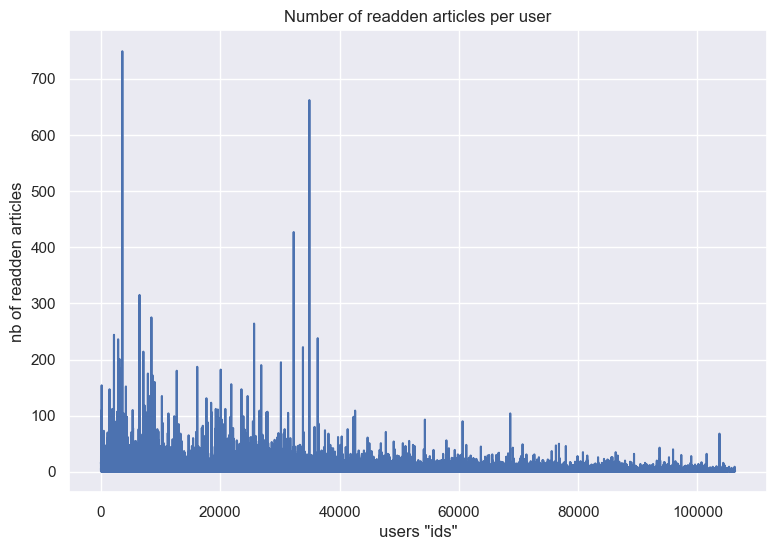

In [40]:
nb_lecture_par_utilisateur.plot(
    y='article_qty', 
    figsize=(9,6), 
    xlabel ='users "ids"', 
    ylabel ='nb of readden articles',
    title='Number of readden articles per user',
    legend = False
);

### On remarque que plus l'id de l'utilisateur monte (donc utilisateur plus récent) plus le nombre de lecture est faible, ce qui peut paraitre logique sur la période d'étude

***
### Visualisons le nombre de lecture par utilisateur de plus près

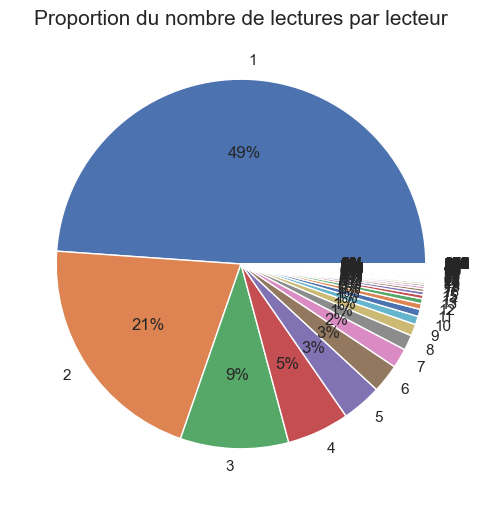

In [41]:
plt.figure(figsize=(9,6))
nb_lecture_par_utilisateur["article_qty"].value_counts().plot.pie(autopct="%1.0f%%")
plt.title("Proportion du nombre de lectures par lecteur", fontsize=15)
plt.ylabel("")
plt.show()

### Pour la même raison qu'évoqué plus tôt, nous allons nous séparer des articles qui n'ont pas au moins été lus 5 fois ou plus, cela va nous permettre de conserver environ 50% des utilisateurs les plus qualitatifs (au moins pour le collaborative filtering)

In [42]:
user_id_2_or_more_readdings = nb_lecture_par_utilisateur[nb_lecture_par_utilisateur['article_qty'] >=5].user_id.tolist()
nb_lecture_par_utilisateur= nb_lecture_par_utilisateur[nb_lecture_par_utilisateur['user_id'].isin(user_id_2_or_more_readdings)]
nb_lecture_par_utilisateur

user_id  article_qty
0             3            6
2             5           17
6            10           12
11           16           14
12           17           20
...         ...          ...
105995   321743            5
106053   321991            5
106148   322334            7
106199   322538            6
106227   322666            9

[16345 rows x 2 columns]

### Voyons à présent les valeurs aberrantes

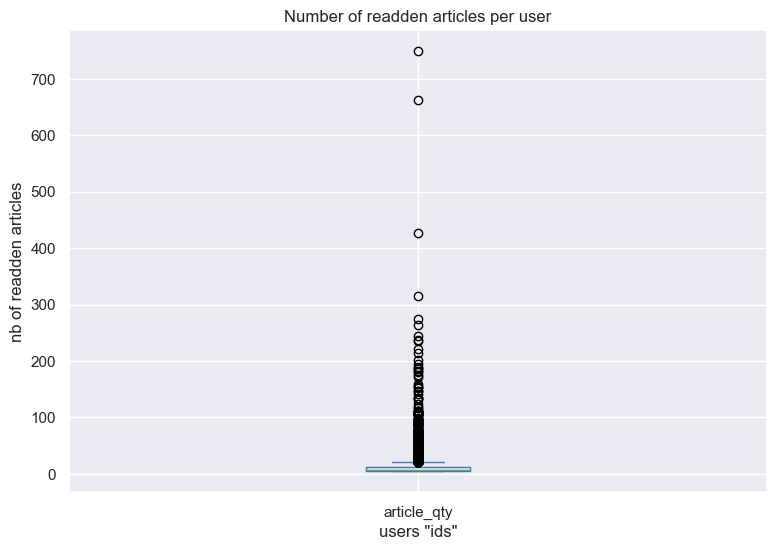

In [43]:
nb_lecture_par_utilisateur.plot(
    kind='box',
    y='article_qty', 
    figsize=(9,6), 
    xlabel ='users "ids"', 
    ylabel ='nb of readden articles',
    title='Number of readden articles per user',
    legend = False
);

### Le nombre de valeurs aberrantes est tellement grand qu'il est difficile de visualiser la boite à moustache (boxplot) !

In [44]:
nb_lecture_par_utilisateur.describe()

user_id   article_qty
count   16345.000000  16345.000000
mean    88849.128908     11.170083
std     72991.009381     14.941432
min         3.000000      5.000000
25%     30310.000000      6.000000
50%     68280.000000      7.000000
75%    133159.000000     12.000000
max    322666.000000    749.000000

### Nous constatons que certains utilisateurs (parmis les 54326 existants) n'ont lu que 2 articles alors que d'autres plus de 749 avec une moyenne de lectures d'article par utilisateur à environ 5, nous devons nous séparer de ces cas extrêmes.

### A noté que la `médiane` est à 3 articles par lecteur.

In [45]:
filtering_var_list = ['article_qty']
bornes_dic = getOutliers(filtering_var_list, nb_lecture_par_utilisateur)
bornes_dic

{'article_qty': [-3.0, 21.0]}

In [46]:
# Le nombre d'article lu ne pouvant être inférieur à 0
# pour une question de commodité, nous pouvons changer
# la borne inférieure
bornes_dic['article_qty'][0] = 0

### A présent, supprimons les lignes d'outliers

In [47]:
### Suppressions des outliers
nb_lecture_par_utilisateur_filtered = cleanOutliers(filtering_var_list, nb_lecture_par_utilisateur, bornes_dic)

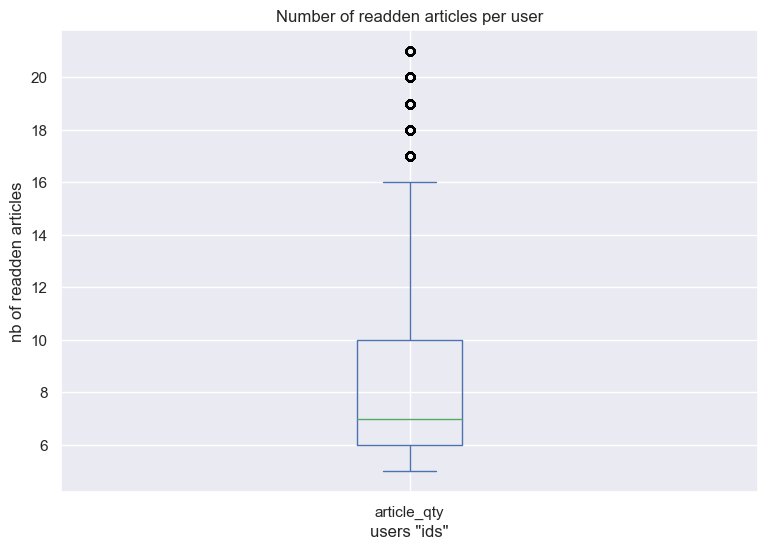

In [48]:
nb_lecture_par_utilisateur_filtered.plot(
    kind='box',
    y='article_qty', 
    figsize=(9,6), 
    xlabel ='users "ids"', 
    ylabel ='nb of readden articles',
    title='Number of readden articles per user',
    legend = False
);

In [49]:
nb_lecture_par_utilisateur_filtered.describe()

user_id   article_qty
count   14922.000000  14922.000000
mean    92341.172966      8.431645
std     73934.365882      3.829616
min         3.000000      5.000000
25%     33457.250000      6.000000
50%     72652.000000      7.000000
75%    139208.250000     10.000000
max    322666.000000     21.000000

### La médiane est toujours à 3, notre suppression des valeurs extrêmes s'est bien déroulée.

### Nous n'avons donc plus que 294006 utilisateurs sur les 322897 initiaux et que les `outliers` ont bien été supprimés et nous nous retrouvons avec une moyenne de lectures d'article par utilisateur qui passe de 9 à 6.
***

### Il nous faut à présent filtrer le dataframe d'origine, `clicks`, sur les 48676 `user_id` restants

In [50]:
user_ids_to_keep = nb_lecture_par_utilisateur_filtered['user_id'].tolist()
clicks=clicks[clicks['user_id'].isin(user_ids_to_keep)]
clicks.describe()

user_id        session_id  session_start  session_size  \
count    125817            125817         125817        125817   
unique    14922             73199          70438            40   
top       96076  1507389923142027  1507389923000             2   
freq         21                19             19         28221   

        click_article_id  click_timestamp  click_environment  \
count             125817           125817             125817   
unique             10674           125804                  3   
top                59034    1507310538572                  4   
freq                  78                2             123772   

        click_deviceGroup  click_os  click_country  click_region  \
count              125817    125817         125817        125817   
unique                  3         8             11            28   
top                     1        17              1            25   
freq                86127     83204         122253         30405   

        click_referrer_type  
count                125817  
unique                    7  
top                       1  
freq                 111507

### Nous partons donc sur un peu moins de 50 000 user et 11 000 articles 

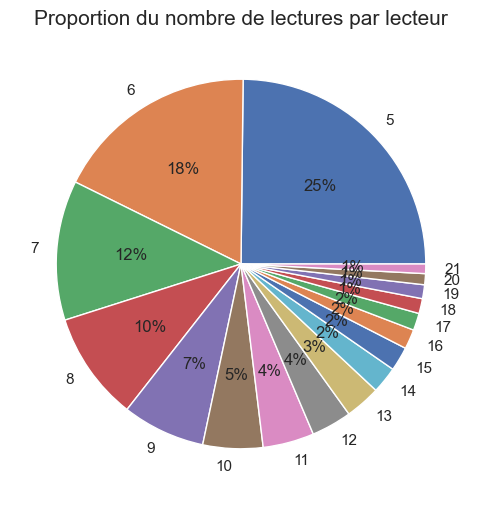

In [51]:
nb_lecture_par_utilisateur = clicks.groupby(by=['user_id']).agg({
    'click_article_id': 'count',
}).rename(columns={"click_article_id": "article_qty"}).reset_index()

plt.figure(figsize=(9,6))
nb_lecture_par_utilisateur["article_qty"].value_counts().plot.pie(autopct="%1.0f%%")
plt.title("Proportion du nombre de lectures par lecteur", fontsize=15)
plt.ylabel("")
plt.show()


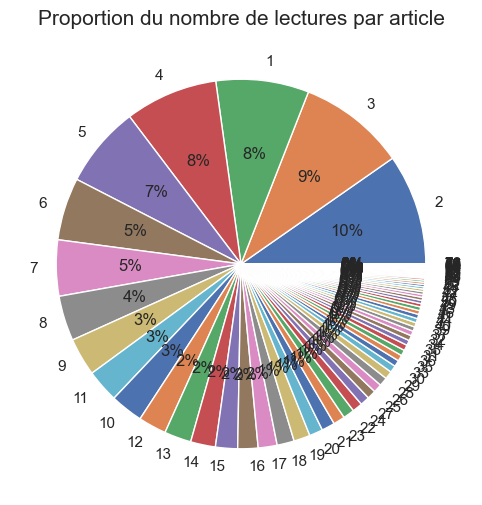

In [52]:
nb_lecture_par_article = clicks.groupby(by=['click_article_id']).agg({
    'user_id': 'count',
}).rename(columns={"user_id": "readings_qty"}).reset_index()


plt.figure(figsize=(9,6))
nb_lecture_par_article["readings_qty"].value_counts().plot.pie(autopct="%1.0f%%")
plt.title("Proportion du nombre de lectures par article", fontsize=15)
plt.ylabel("")
plt.show()

<a class="anchor" id="chapitre2"></a><hr><center><b><h1><font color=orange>2/ Les différentes approches</font></h1></b></center><hr>[](#sommaire)

<a class="anchor" id="partie_2_1"></a><b><h2><font color=purple>2.1/ Content Based Filtering</font></h2></b>

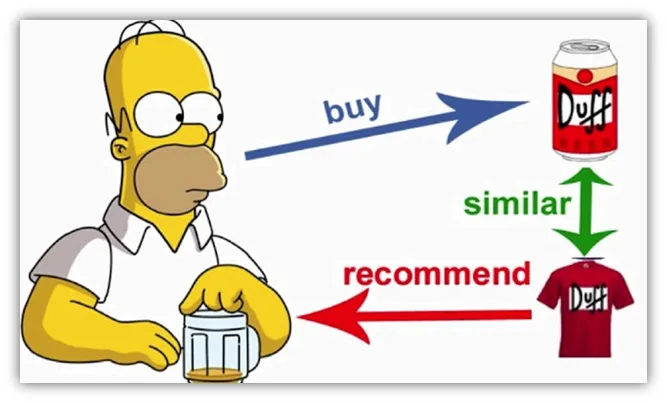

<a class="anchor" id="partie_2_1_1"></a><b><h3><font color=blue>2.1.1/ Préparation des données</font></h3></b>

***
### Nous devons tout d'abord créer le profile utilisateur en terme d'article lus de chaque lecteur<br>Pour ce faire, il nous faut récupérer la liste des articles lus de chaque lecteur

In [53]:
nb_lecture_par_utilisateur = clicks.groupby(by=['user_id']).agg({
    'click_article_id': lambda x: list(x),
}).reset_index()
nb_lecture_par_utilisateur

user_id                                   click_article_id
0            3   [236065, 236294, 234686, 235665, 236671, 235745]
1            5  [286413, 59929, 60253, 348132, 282785, 202763,...
2           10  [198420, 198322, 142116, 5341, 198321, 199227,...
3           16  [162286, 206233, 256163, 29828, 331622, 107289...
4           17  [264013, 157861, 348103, 88912, 88911, 161907,...
...        ...                                                ...
14917   321743           [294107, 294111, 121785, 353415, 173546]
14918   321991            [158158, 159927, 156158, 168377, 76393]
14919   322334  [84911, 84288, 83549, 84100, 84681, 83406, 83770]
14920   322538         [72336, 72335, 72334, 72333, 72329, 72330]
14921   322666  [331149, 361585, 330990, 273348, 270958, 1973,...

[14922 rows x 2 columns]

### Puis regroupons toutes les valeurs en 1 seul vecteur et supprimons les 250 colonnes dans `articles_embedding_df`

In [54]:
articles_embedding_df

0         1         2         3         4         5         6    \
1779   -0.647006 -0.966940  0.325817  0.358826 -0.118850 -0.612922 -0.584846   
1799    0.413194 -0.968066 -0.309979  0.212062 -0.678009  0.193126 -0.628883   
1843    0.177777 -0.973838  0.596479 -0.116012 -0.132682  0.177583 -0.729617   
1844    0.004446 -0.976708  0.572236 -0.314808 -0.025350 -0.045349 -0.529130   
1873   -0.830512 -0.972994 -0.153895 -0.792031 -0.134451 -0.098033 -0.463854   
...          ...       ...       ...       ...       ...       ...       ...   
363967  0.236928 -0.956834  0.006191  0.088201 -0.242906  0.357756 -0.345632   
363976  0.159935 -0.952279  0.314072  0.427590 -0.417508  0.590483 -0.658550   
363984 -0.078119 -0.938926 -0.100879  0.187424 -0.263362  0.421119 -0.340249   
364017  0.290270 -0.963398 -0.019136  0.596347 -0.589016 -0.091982  0.223495   
364043 -0.136932 -0.995471  0.991298  0.031871 -0.915622 -0.658517  0.633090   

             7         8         9    ...       240       241       242  \
1779    0.244543 -0.378769  0.008750  ...  0.895972 -0.112508  0.107309   
1799    0.376057 -0.540502  0.434909  ...  0.453507  0.176024  0.293311   
1843    0.285325 -0.745830  0.388505  ... -0.227457  0.307700  0.821314   
1844    0.525533 -0.539433 -0.185396  ...  0.607655  0.064378  0.377659   
1873    0.115519 -0.338546  0.324914  ...  0.365637  0.347666  0.752585   
...          ...       ...       ...  ...       ...       ...       ...   
363967  0.286124  0.104092  0.283913  ...  0.013519 -0.167056 -0.274619   
363976  0.639678  0.448397  0.042278  ... -0.092084 -0.118025 -0.296096   
363984  0.136430  0.125477 -0.055080  ... -0.137777  0.278850  0.033872   
364017 -0.072997  0.472463  0.119069  ...  0.850100  0.234533  0.005308   
364043 -0.564356  0.676551 -0.446068  ... -0.681986 -0.574185 -0.536908   

             243       244       245       246       247       248       249  
1779   -0.732379 -0.249687  0.159403 -0.527575 -0.607573  0.534473  0.431893  
1799   -0.629847 -0.488028  0.389765 -0.818524 -0.264035  0.495336 -0.577006  
1843   -0.455239 -0.850743  0.920860 -0.025265 -0.251134 -0.612494  0.315490  
1844   -0.751397 -0.618729  0.738524 -0.641455 -0.472870  0.685716 -0.265893  
1873   -0.694851 -0.533168  0.610355 -0.709239 -0.563662  0.772045 -0.520287  
...          ...       ...       ...       ...       ...       ...       ...  
363967 -0.330137 -0.204780 -0.008638 -0.228098 -0.006074 -0.201296  0.172648  
363976 -0.256414 -0.010864  0.395360  0.450012 -0.049759 -0.199239  0.328345  
363984  0.139476  0.371041  0.152439 -0.173326  0.286714  0.145306 -0.177012  
364017 -0.169417  0.443876  0.299790  0.257217  0.615377  0.048421 -0.309620  
364043  0.688934  0.528204  0.162435  0.940364  0.989298 -0.761595 -0.414652  

[11198 rows x 250 columns]

In [55]:
def get_article_embeddings(article_id, articles_embedding):
    """
    renvoie pour un article id son vecteur d'embedding

    Args:
        article_id: article id
        articles_embedding: article embeddings dataframe

    Returns:
        article_embedding_vec: numpy array
    """
    
    article_embedding_vec = articles_embedding.loc[article_id].to_numpy()
    
    return article_embedding_vec

In [56]:
articles_embedding_df_new = articles_embedding_df.reset_index()[['index']]
articles_embedding_df_new.rename(columns={"index": "article_id"}, inplace=True)


articles_embedding_df_new['vect'] = articles_embedding_df_new['article_id'].apply(
    lambda x: get_article_embeddings(x, articles_embedding_df)
)

articles_embedding_df_new

article_id                                               vect
0            1779  [-0.64700645, -0.9669398, 0.3258166, 0.3588261...
1            1799  [0.4131941, -0.9680658, -0.3099792, 0.21206166...
2            1843  [0.1777766, -0.9738377, 0.5964793, -0.11601178...
3            1844  [0.004446265, -0.9767077, 0.57223576, -0.31480...
4            1873  [-0.8305119, -0.9729942, -0.15389454, -0.79203...
...           ...                                                ...
11193      363967  [0.23692812, -0.95683354, 0.0061911, 0.0882007...
11194      363976  [0.15993546, -0.9522793, 0.3140724, 0.42758992...
11195      363984  [-0.07811948, -0.938926, -0.100879, 0.18742438...
11196      364017  [0.29026955, -0.96339834, -0.019135717, 0.5963...
11197      364043  [-0.13693178, -0.9954715, 0.99129796, 0.031870...

[11198 rows x 2 columns]

In [57]:
#nb_lecture_par_utilisateur[nb_lecture_par_utilisateur['click_article_id'].apply(lambda x: len(x)>2)]
#clicks[clicks['user_id']==80]
#articles_embedding_df.loc[27].to_numpy()*2
#articles_embedding_df.loc[27]*2
#(articles_embedding_df.loc[236065][0] + articles_embedding_df.loc[234686][0]) /2 

In [58]:
def get_mean_article_embeddings_per_user_reading(click_article_ids, articles_embedding):
    """
    Parcours une liste d'article ids lus par 1 utilisateur
    puis construit et renvoie la moyenne pondérée des
    embeddings d'article correspondant

    Args:
        click_article_ids: list of article ids
        articles_embedding: article embeddings dataframe

    Returns:
        mean_article_embedding: mean article embedding numpy vector
    """
    
    total_readding = len(click_article_ids)
    # Init vector that gonna contain mean article embedding values
    mean_article_embedding = np.zeros(250)
    
    # Parsing all article ids and retrieving adding corresponding embeddings
    for article_id in click_article_ids:
        mean_article_embedding += articles_embedding.loc[article_id].to_numpy()
        
    # Doing the mean
    mean_article_embedding = mean_article_embedding / total_readding
    
    return mean_article_embedding

In [59]:
nb_lecture_par_utilisateur['ref_vect'] = nb_lecture_par_utilisateur.click_article_id.apply(
    lambda x: get_mean_article_embeddings_per_user_reading(x, articles_embedding_df)
)
nb_lecture_par_utilisateur

user_id                                   click_article_id  \
0            3   [236065, 236294, 234686, 235665, 236671, 235745]   
1            5  [286413, 59929, 60253, 348132, 282785, 202763,...   
2           10  [198420, 198322, 142116, 5341, 198321, 199227,...   
3           16  [162286, 206233, 256163, 29828, 331622, 107289...   
4           17  [264013, 157861, 348103, 88912, 88911, 161907,...   
...        ...                                                ...   
14917   321743           [294107, 294111, 121785, 353415, 173546]   
14918   321991            [158158, 159927, 156158, 168377, 76393]   
14919   322334  [84911, 84288, 83549, 84100, 84681, 83406, 83770]   
14920   322538         [72336, 72335, 72334, 72333, 72329, 72330]   
14921   322666  [331149, 361585, 330990, 273348, 270958, 1973,...   

                                                ref_vect  
0      [-0.633888045946757, -0.9576329489549001, -0.4...  
1      [0.03758495080503909, -0.9648358085576225, 0.1...  
2      [-0.42235957831144333, -0.9588247289260229, -0...  
3      [-0.26575193447726114, -0.9233078871454511, 0....  
4      [-0.15422873795032502, -0.9321221619844436, -0...  
...                                                  ...  
14917  [-0.4039882570505142, -0.9399216771125793, -0....  
14918  [-0.1290243998169899, -0.9631192803382873, -0....  
14919  [-0.63419588362532, -0.9585439903395516, -0.48...  
14920  [0.7768468260765076, -0.8668341636657715, 0.44...  
14921  [-0.7071492142147489, -0.9736078580220541, 0.0...  

[14922 rows x 3 columns]

<a class="anchor" id="partie_2_1_2"></a><b><h3><font color=blue>2.1.2/ Calcul de la similarité du cosinus</font></h3></b>

In [60]:
def get_content_base_recommendations(articles_embedding, users_profil):
    """
    Parcours une liste de vecteur de réference issue de profil utilisateur
    et cherche dans une liste d'embedding d'article celui qui se 
    rapproche le plus du profil et en retourne l'article id ainsi 
    que le vecteur d'embedding

    Args:
        articles_embedding: dataframe des embeddings d'article
        users_profil: dataframe des embeddings de profil utilisateur "ref_vect"

    Returns:
        recomendations: article id et vecteur d'embedding correspondant
    """
    
    # Inits
    recomendations = {
        'article_id' : [],
        'vects' : []
    }
    
    article_embeddings_vects = articles_embedding["vect"]
    
    # Pour chaque ligne de profil utilisateur
    for i, r in tqdm(users_profil.iterrows(), total=len(users_profil)):

        # On recupère le vecteur de profil utilisateur
        user_vect = r["ref_vect"]

        # On construit une liste de score de similarité de cosinus
        cos_similarities = [cosine_similarity([user_vect], [x])[0][0] for x in article_embeddings_vects]
        assert len(article_embeddings_vects) == len(cos_similarities)

        # On recupère l'index du meilleure score de similarité de cosinus
        # Index qui permet directement d'interroger le dataframe des embedding d'article (articles_embedding)
        best_similarity_index = np.argmax(cos_similarities)
        
        # On construit la liste de recommandations [article_id]
        best_item_for_user_article_id = articles_embedding.iloc[best_similarity_index]["article_id"]
        recomendations['article_id'].append(best_item_for_user_article_id)
        
        # On construit la liste de recommandations [vecteur embedding de recommandations]
        best_item_for_user_vect = articles_embedding.iloc[best_similarity_index]["vect"]
        recomendations['vects'].append(best_item_for_user_vect)
    
    return recomendations

***
<a class="anchor" id="partie_2_1_3"></a><b><h3><font color=blue>2.1.3/ Recommandations</font></h3></b>

In [61]:
already_executed = True
var_backup_filename = "content_base_filtering_recommandations.pckl"

# Pour la première execution du code
if not already_executed:    
    recomendations = get_content_base_recommendations(articles_embedding_df_new, nb_lecture_par_utilisateur)
    
    #sauvegarde dans un fichier pickle car sinon 7h de calculs seront effectuées
    f = open(var_backup_filename, 'wb')
    pickle.dump(recomendations, f)
    f.close()

# Pour les executions suivantes
else:
    f = open(var_backup_filename, 'rb')
    recomendations = pickle.load(f)
    f.close()

In [62]:
# TEST
first_user_id_profil_vect = nb_lecture_par_utilisateur.iloc[0]['ref_vect']
first_user_recommendation_vect = recomendations['vects'][0]

cosin_score = cosine_similarity([first_user_id_profil_vect], [first_user_recommendation_vect])[0][0]

print("Le score de similarité du cosinus pour le premier utilisateur \n"
      F"avec la recommandation qui lui a été faite est de : {cosin_score}")

Le score de similarité du cosinus pour le premier utilisateur 
avec la recommandation qui lui a été faite est de : 0.9154384616899848


In [63]:
recomendations

{'article_id': [236294,
  348590,
  198859,
  283876,
  283436,
  286417,
  237851,
  304492,
  352098,
  177749,
  288686,
  195032,
  158513,
  237209,
  61457,
  69463,
  118773,
  293210,
  107226,
  271053,
  145119,
  156457,
  195908,
  301104,
  160964,
  30510,
  282359,
  47723,
  255703,
  107253,
  293279,
  226374,
  224788,
  160532,
  57668,
  304558,
  352159,
  177749,
  270599,
  141013,
  234220,
  293083,
  273566,
  270399,
  285218,
  300016,
  286404,
  31817,
  159710,
  123454,
  236179,
  236289,
  182057,
  293110,
  84137,
  129086,
  285075,
  107043,
  298790,
  288984,
  76548,
  286086,
  187422,
  16981,
  48743,
  48586,
  217852,
  114853,
  331906,
  217764,
  361700,
  360463,
  187014,
  195430,
  138215,
  49067,
  32634,
  237679,
  224864,
  96645,
  207543,
  16981,
  107209,
  337762,
  213871,
  160565,
  10253,
  348624,
  271943,
  270570,
  284912,
  360702,
  236482,
  298790,
  355549,
  312557,
  118774,
  236289,
  270256,
  313556,
  

<a class="anchor" id="partie_2_2"></a><b><h2><font color=purple>2.2/ Collaborative filtering</font></h2></b>

***
<a class="anchor" id="partie_2_2_1"></a><b><h3><font color=blue>2.1.1/ Préparation des données</font></h3></b>

In [64]:
nb_lecture_par_utilisateur

user_id                                   click_article_id  \
0            3   [236065, 236294, 234686, 235665, 236671, 235745]   
1            5  [286413, 59929, 60253, 348132, 282785, 202763,...   
2           10  [198420, 198322, 142116, 5341, 198321, 199227,...   
3           16  [162286, 206233, 256163, 29828, 331622, 107289...   
4           17  [264013, 157861, 348103, 88912, 88911, 161907,...   
...        ...                                                ...   
14917   321743           [294107, 294111, 121785, 353415, 173546]   
14918   321991            [158158, 159927, 156158, 168377, 76393]   
14919   322334  [84911, 84288, 83549, 84100, 84681, 83406, 83770]   
14920   322538         [72336, 72335, 72334, 72333, 72329, 72330]   
14921   322666  [331149, 361585, 330990, 273348, 270958, 1973,...   

                                                ref_vect  
0      [-0.633888045946757, -0.9576329489549001, -0.4...  
1      [0.03758495080503909, -0.9648358085576225, 0.1...  
2      [-0.42235957831144333, -0.9588247289260229, -0...  
3      [-0.26575193447726114, -0.9233078871454511, 0....  
4      [-0.15422873795032502, -0.9321221619844436, -0...  
...                                                  ...  
14917  [-0.4039882570505142, -0.9399216771125793, -0....  
14918  [-0.1290243998169899, -0.9631192803382873, -0....  
14919  [-0.63419588362532, -0.9585439903395516, -0.48...  
14920  [0.7768468260765076, -0.8668341636657715, 0.44...  
14921  [-0.7071492142147489, -0.9736078580220541, 0.0...  

[14922 rows x 3 columns]

In [65]:
%%time
#INIT des variables

# Nombre de lecture unique par utilisateur_id
# ex : utilisateur_id=10 avec 2 * article_X lus + 3 * article_Y lus 
# on aura alors reads_by_user[10] = 2
reads_by_user = {} # pas forcément utile si l'on execute le code d'une traite

# Liste des Utilisateur_id pour 1 item_id unique lu
# ex : si l'utilisateur 10 à lu 4 articles differents, alors
# users_ids ressemblera à : [[x, x]...[10, 10, 10, 10]...[y, y, y]]
users_ids = []

# va contenir les articles_id (tableau ou liste) pour chaque user 
# ex: reads[10] = tableau (ou liste) des articles_id UNIQUE du user_id 10
reads = []

# va contenir la liste du nb de lecture du même article pour 1 user
# ex: clicks_qty[10] = tableau (ou liste) du nombre de lecture de chaque article lus par le user 10
clicks_qty = []

df_to_parse = nb_lecture_par_utilisateur

#ALGO de remplissages des variables

# Pour chaque ligne de profil utilisateur
for i, r in tqdm(df_to_parse.iterrows(), total=len(df_to_parse)):
        
    # récupération du user    
    current_user_id = r['user_id']
    
    # récupération de la liste des articles    
    article_ids = r['click_article_id']
    
    #INIT des counters
    users_ids_counter_list = []
    reads_counter_list = []
    clicks_qty_counter_list = []
    
    # va contenir la liste des articles_id unique 
    # ainsi que le nombre de fois qu'ils ont lus par le user
    article_ids_unique_count = {}
    
    # List permettant de detecter les articles_id unique
    article_ids_unique = []
    
    # Pour chaque article de la liste d'articles lu par le user
    for article_id in article_ids:
        if article_id in article_ids_unique:
            # article_id a deja été lu, on incrémente son comptage
            article_ids_unique_count[article_id] += 1
        else:
            # Si article_id n'est pas dans article_ids_unique, on l'ajoute
            article_ids_unique.append(article_id)
            # On initialise son comptage
            article_ids_unique_count[article_id] = 1
            # Et on remplis les compteurs uniques
            users_ids_counter_list.append(current_user_id)
            reads_counter_list.append(article_id)
            
    for article_id in article_ids_unique:
        clicks_qty_counter_list.append(article_ids_unique_count[article_id])

    
    # on peut à présent remplire les variables globales
    reads_by_user[current_user_id] = len(article_ids_unique)
    
    users_ids.append(users_ids_counter_list)
    reads.append(reads_counter_list)
    clicks_qty.append(clicks_qty_counter_list)

100%|██████████| 14922/14922 [00:00<00:00, 20216.07it/s]

CPU times: total: 422 ms
Wall time: 740 ms


In [66]:
'''
reads_by_user
users_ids
reads
clicks_qty
''';

In [67]:
df = pd.DataFrame(zip(np.concatenate(users_ids), np.concatenate(reads), np.concatenate(clicks_qty)), columns=["user_id", "article_id", "nb_click"])
df

user_id  article_id  nb_click
0             3      236065         1
1             3      236294         1
2             3      234686         1
3             3      235665         1
4             3      236671         1
...         ...         ...       ...
123843   322666      270958         1
123844   322666        1973         1
123845   322666      313257         1
123846   322666      360547         1
123847   322666      313556         1

[123848 rows x 3 columns]

In [68]:
nb_lecture_par_utilisateur_pivot = pd.pivot_table(df, values="nb_click", index="user_id", columns="article_id").fillna(0)
nb_lecture_par_utilisateur_pivot

article_id  1779    1799    1843    1844    1873    1877    1885    1895    \
user_id                                                                      
3              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10             0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
16             0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
17             0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
321743         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
321991         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
322334         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
322538         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
322666         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

article_id  1932    1933    ...  363921  363925  363932  363947  363952  \
user_id                     ...                                           
3              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
5              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
10             0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
16             0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
17             0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
...            ...     ...  ...     ...     ...     ...     ...     ...   
321743         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
321991         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
322334         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
322538         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
322666         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

article_id  363967  363976  363984  364017  364043  
user_id                                             
3              0.0     0.0     0.0     0.0     0.0  
5              0.0     0.0     0.0     0.0     0.0  
10             0.0     0.0     0.0     0.0     0.0  
16             0.0     0.0     0.0     0.0     0.0  
17             0.0     0.0     0.0     0.0     0.0  
...            ...     ...     ...     ...     ...  
321743         0.0     0.0     0.0     0.0     0.0  
321991         0.0     0.0     0.0     0.0     0.0  
322334         0.0     0.0     0.0     0.0     0.0  
322538         0.0     0.0     0.0     0.0     0.0  
322666         0.0     0.0     0.0     0.0     0.0  

[14922 rows x 10674 columns]

In [69]:
'''
nb_lecture_par_utilisateur.iloc[4]['click_article_id']
nb_lecture_par_utilisateur_pivot.iloc[4][88913]
''';

In [70]:
readings_sparse_vect_df = pd.DataFrame(
    zip(nb_lecture_par_utilisateur_pivot.index, nb_lecture_par_utilisateur_pivot.to_numpy())
    ,columns=["user_id", "readings_sparse_vect"]
)
readings_sparse_vect_df

user_id                               readings_sparse_vect
0            3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1            5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2           10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3           16  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4           17  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
...        ...                                                ...
14917   321743  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
14918   321991  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
14919   322334  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
14920   322538  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
14921   322666  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[14922 rows x 2 columns]

***
<a class="anchor" id="partie_2_2_2"></a><b><h3><font color=blue>2.2.2/ Calcul de la similarité du cosinus</font></h3></b>

In [71]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b): 
    return dot(a, b)/(norm(a)*norm(b))

In [72]:
def get_not_readden_recommended_articles_ids(current_user_reads, recommended_user_reads, articles_ids_reads_df):
    """
    Compare les tableaux de lectures du user courant et du user recommandé pour en retourner 
    les articles_id non lus par ce dernier    

    Args:
        current_user_reads: dataframe des lectures d'articles_id transformés en matrice creuse
        recommended_user_reads: dataframe des embeddings de profil utilisateur "ref_vect"
        articles_ids_reads_df: dataframe des des lectures d'articles_id en colonne

    Returns:
        article_ids: article ids non lu par le user courant mais lus par le user recommandé
    """
    current_user_not_readden_index = np.where( current_user_reads == 0 )
    recommended_user_eadden_index = np.where( recommended_user_reads > 0 )
    common_index_pos = np.intersect1d(current_user_not_readden_index, recommended_user_eadden_index)
    article_ids = articles_ids_reads_df.columns[common_index_pos].tolist()
    
    return article_ids

In [73]:
def get_collaborative_recommendations(sparse_vect_df, users_readdings_pivot):
    """
    Parcours un dataframe de matrice creuse de lectures d'articles (pour 1 user)
    et compare la similarité du cosinus avec l'ensemble des lectures de tous les users.
    On renvoie le user_id recommandé avec les article_ids non lu par le user courant

    Args:
        sparse_vect_df: dataframe des lectures d'articles_id transformés en matrice creuse (readings_sparse_vect)
        users_readdings_pivot: dataframe des des lectures d'articles_id en colonne

    Returns:
        recomendations: user_id recommandé avec les article_ids non lu par le user courant 
    """
    
    readings_sparse_vect = sparse_vect_df["readings_sparse_vect"]
    
    # Inits
    
    recomendations = {}
    
    test = []
        
    # Pour chaque ligne de profil utilisateur
    for i, r in tqdm(sparse_vect_df.iterrows(), total=len(sparse_vect_df)):

        # On recupère le vecteur de profil utilisateur
        user_vect = r['readings_sparse_vect']
        
        # INIT
        current_user_id = r['user_id']
        recomendations[current_user_id] = {
            'user_id' : 0,
            'cos_similarities_score':0,
            'article_ids' : []
        }

        
        # On construit une liste de score de similarité de cosinus
        #cos_similarities = [cosine_similarity([user_vect], [x])[0][0] for x in readings_sparse_vect] # TROP LENT !!!
        
        # On prend bien soin d'exclure une valeur de 1 pour le user qui serait comparé à lui-même
        cos_similarities = [cos_sim(user_vect, x) if (user_vect != x).any() else 0 for x in readings_sparse_vect]
        #assert len(readings_sparse_vect) == len(cos_similarities)
        
         
        # On recupère l'index du meilleure score de similarité de cosinus
        # Index qui permet directement d'interroger le dataframe des lecture d'article (users_readdings_pivot)
        best_similarity_index = np.argmax(cos_similarities)
        
        # current_user_reads_vect = user_vect
        recommended_user_reads_vect = sparse_vect_df.iloc[best_similarity_index]["readings_sparse_vect"]
        
        article_ids = get_not_readden_recommended_articles_ids(
            user_vect, 
            recommended_user_reads_vect, 
            users_readdings_pivot
        )
        
        # On remplis les recommendations
        recomendations[current_user_id]['user_id'] = sparse_vect_df.iloc[best_similarity_index]["user_id"]
        recomendations[current_user_id]['cos_similarities_score'] = cos_similarities[best_similarity_index]
        recomendations[current_user_id]['article_ids'] = article_ids
        
        
    return recomendations

***
<a class="anchor" id="partie_2_2_3"></a><b><h3><font color=blue>2.2.3/ Recommandations</font></h3></b>

In [74]:
already_executed = True
var_backup_filename_collaborative = "collaborative_filtering_recommandations.pckl"

# Pour la première execution du code
if not already_executed:    
    recomendations_collaborative = get_collaborative_recommendations(readings_sparse_vect_df, nb_lecture_par_utilisateur_pivot)
    
    #sauvegarde dans un fichier pickle car sinon 7h de calculs seront effectuées
    f = open(var_backup_filename_collaborative, 'wb')
    pickle.dump(recomendations_collaborative, f)
    f.close()

# Pour les executions suivantes
else:
    f = open(var_backup_filename_collaborative, 'rb')
    recomendations_collaborative = pickle.load(f)
    f.close()

In [75]:
'''
# TEST
first_user_id_profil_vect = nb_lecture_par_utilisateur.iloc[0]['ref_vect']
first_user_recommendation_vect = recomendations['vects'][0]

cosin_score = cosine_similarity([first_user_id_profil_vect], [first_user_recommendation_vect])[0][0]

print("Le score de similarité du cosinus pour le premier utilisateur \n"
      F"avec la recommandation qui lui a été faite est de : {cosin_score}")
''';

In [76]:
recomendations_collaborative

{3: {'user_id': 27813,
  'cos_similarities_score': 0.2970442628930023,
  'article_ids': [206805, 214835]},
 5: {'user_id': 125846,
  'cos_similarities_score': 0.2300894966542111,
  'article_ids': [128232, 128345, 129540, 129675]},
 10: {'user_id': 258657,
  'cos_similarities_score': 0.3273268353539886,
  'article_ids': [198384, 199278, 199393, 209296]},
 16: {'user_id': 58846,
  'cos_similarities_score': 0.23904572186687872,
  'article_ids': [255147, 255595, 255747]},
 17: {'user_id': 224168,
  'cos_similarities_score': 0.5640760748177662,
  'article_ids': []},
 18: {'user_id': 146588,
  'cos_similarities_score': 0.3086066999241838,
  'article_ids': [298011, 298471, 298756, 299227]},
 22: {'user_id': 12422,
  'cos_similarities_score': 0.2279211529192759,
  'article_ids': [71454, 234000, 234346, 236328, 348104]},
 23: {'user_id': 72642,
  'cos_similarities_score': 0.22360679774997896,
  'article_ids': [58258, 198551, 198554]},
 25: {'user_id': 78165,
  'cos_similarities_score': 0.474341

<a class="anchor" id="chapitre3"></a><hr><center><b><h1><font color=orange>3/ Recommandations classées par ordre de similarité </font></h1></b></center><hr>[](#sommaire)

<a class="anchor" id="partie_3_1"></a><b><h2><font color=purple>3.1/ Principe</font></h2></b>

***
## Le dictionnaire `recomendations_collaborative` ci-dessus nous donne la base de notre futur dictionnaire.
## A partir de ce dernier, qui fournit la liste des articles non lus et recommandés pour 1 user, nous allons classer les articles proposés par ordre d'intérêt !
## En effet, grâce au 2 dataframes `nb_lecture_par_utilisateur` (profil utilisateur) et `articles_embedding_df_new` (profile article) nous allons classer les articles proposés par ordre décroissant de similarité de cosinus !
## Nous sauvegarderons le nouveau dictionnaire ainsi crée dans un fichier pickle pour une future utilisation

<a class="anchor" id="partie_3_2"></a><b><h2><font color=purple>3.2/ Calcul et sauvegarde pour future application</font></h2></b>

In [77]:
def get_sorted_recomendations(collab_df, user_reads_df, articles_vects_df):
    
    """
    Args:
        collab_df: dataframe (recomendations_collaborative)
        user_reads_df: dataframe (nb_lecture_par_utilisateur)
        articles_vects_df: dataframe (articles_embedding_df_new)
        

    Returns:
        recomendations: dictionnary
    """
    
    
    #i=0

    #Init du dictionnaire qui va contenir les recommandations classées des users
    recomendations = {}

    # Nous parcourons la liste des users issu du collaborative filtering
    for user in tqdm(collab_df, total=len(collab_df)):        

        # Nous récupérons le vecteur du user_profil qui a servi au content base filtering 
        user_profil_vec = user_reads_df[user_reads_df['user_id']==user]['ref_vect'].tolist()[0].tolist()

        # Ainsi que la liste des articles recommandés et non lus pour le user courant
        article_ids = collab_df[user]['article_ids']

        # Initialisation du dictionnaire des score de similarité du cosinus
        cos_similarities = {}

        # Nous parcourons la liste des articles ids recommandés
        for article_id in article_ids:

            # Nous récupérons le vecteur de l'article qui a servi au content base filtering
            article_vec = articles_vects_df[articles_vects_df['article_id']==article_id]['vect'].tolist()[0].tolist()

            #Nous ajoutons le score entre les 2 vecteurs (user_profil, article) au dictionnaire     
            cos_similarities[article_id]=cos_sim(user_profil_vec, article_vec)


        # Nous trions le dictionnaire résultant en par ordre de score décroissant
        sorted_cosim = dict(sorted(cos_similarities.items(), key=lambda item: item[1] , reverse = True))

        # Et l'ajoutons au dictionnaire final
        recomendations[user] = sorted_cosim

        # Et nous passons au user suivant !

        #i+=1
        #if i==3:  
            #break
            
    # On retourne le dictionnaire ainsi formé
    return recomendations

### Enregistrement des recommandations classées

In [78]:
already_executed = True
var_backup_filename_collaborative = "sorted_recomendations.pckl"

# Pour la première execution du code
if not already_executed:    
    sorted_recomendations = get_sorted_recomendations(
        recomendations_collaborative, 
        nb_lecture_par_utilisateur, 
        articles_embedding_df_new
    )
    
    #sauvegarde dans un fichier pickle car sinon 7h de calculs seront effectuées
    f = open(var_backup_filename_collaborative, 'wb')
    pickle.dump(sorted_recomendations, f)
    f.close()

# Pour les executions suivantes
else:
    f = open(var_backup_filename_collaborative, 'rb')
    sorted_recomendations = pickle.load(f)
    f.close()

In [79]:
sorted_recomendations

{3: {206805: 0.5306160600917954, 214835: 0.23524724321797658},
 5: {128232: 0.5531744642311749,
  128345: 0.5170880793577127,
  129540: 0.3649472589894927,
  129675: 0.34512142126641593},
 10: {198384: 0.881771485633137,
  199393: 0.8125351013711855,
  199278: 0.7927375061222541,
  209296: 0.2559260270339632},
 16: {255595: 0.6649543450861952,
  255747: 0.5766670464758589,
  255147: 0.5620009467380364},
 17: {},
 18: {298756: 0.6439677924317349,
  299227: 0.5688947906117171,
  298471: 0.5548977529930996,
  298011: 0.5320085339284397},
 22: {234346: 0.6294163520424889,
  236328: 0.5816286868756002,
  234000: 0.5757945585691974,
  348104: 0.5487988545329023,
  71454: 0.5309624068306252},
 23: {198554: 0.6010906143208071,
  58258: 0.4622565250180518,
  198551: 0.3587178840790229},
 25: {353684: 0.6948654111036907,
  351587: 0.6319791208494758,
  36709: 0.23545621048095008},
 26: {124716: 0.6636495979634452,
  5113: 0.5670547535927768,
  237598: 0.5266027383760956,
  59690: 0.4417616341352

### Dans ce dictionnaire final, nous n'avons plus de notions de collaborative filtering(pas de user_id correspondant) mais juste une liste de recommandations d'articles non lus pour le user (en cléf du dictionnaire) et classés par ordre décroissant d'intérêt

<a class="anchor" id="chapitre4"></a><hr><center><b><h1><font color=orange>4/ Bonus : modèle externe via la librairie Surprise</font></h1></b></center><hr>[](#sommaire)

### Surprise est une bibliothèque qui va nous permettre de faire de recommandations de contenu.
### Pour ce faire nous devons d'abord formater nos données d'entrée sous forme d'un dataframe contenant 3 colonnes : `user_id`, `article_id` et `rating`.
### Ce qui nous àmène à définir ce qu'est le `rating` ou score que l'on souhaite attribuer au couple user_id / article_id

<a class="anchor" id="partie_4_1"></a><b><h2><font color=purple>4.1/ Préparation des données</font></h2></b>

In [80]:
clicks.describe()

user_id        session_id  session_start  session_size  \
count    125817            125817         125817        125817   
unique    14922             73199          70438            40   
top       96076  1507389923142027  1507389923000             2   
freq         21                19             19         28221   

        click_article_id  click_timestamp  click_environment  \
count             125817           125817             125817   
unique             10674           125804                  3   
top                59034    1507310538572                  4   
freq                  78                2             123772   

        click_deviceGroup  click_os  click_country  click_region  \
count              125817    125817         125817        125817   
unique                  3         8             11            28   
top                     1        17              1            25   
freq                86127     83204         122253         30405   

        click_referrer_type  
count                125817  
unique                    7  
top                       1  
freq                 111507

In [81]:
user_article = clicks.groupby(['user_id', 'click_article_id']).count().reset_index()
user_article

user_id  click_article_id  session_id  session_start  session_size  \
0             3            234686           1              1             1   
1             3            235665           1              1             1   
2             3            235745           1              1             1   
3             3            236065           1              1             1   
4             3            236294           1              1             1   
...         ...               ...         ...            ...           ...   
123843   322666            313556           1              1             1   
123844   322666            330990           1              1             1   
123845   322666            331149           1              1             1   
123846   322666            360547           1              1             1   
123847   322666            361585           1              1             1   

        click_timestamp  click_environment  click_deviceGroup  click_os  \
0                     1                  1                  1         1   
1                     1                  1                  1         1   
2                     1                  1                  1         1   
3                     1                  1                  1         1   
4                     1                  1                  1         1   
...                 ...                ...                ...       ...   
123843                1                  1                  1         1   
123844                1                  1                  1         1   
123845                1                  1                  1         1   
123846                1                  1                  1         1   
123847                1                  1                  1         1   

        click_country  click_region  click_referrer_type  
0                   1             1                    1  
1                   1             1                    1  
2                   1             1                    1  
3                   1             1                    1  
4                   1             1                    1  
...               ...           ...                  ...  
123843              1             1                    1  
123844              1             1                    1  
123845              1             1                    1  
123846              1             1                    1  
123847              1             1                    1  

[123848 rows x 12 columns]

In [82]:
user_article['session_id'].sum() # session_id pris arbitrairement

125817

### Il y a donc environ 2000 articles qui ont été lus plus d'une fois par le même utilisateur ), voyons cette range de `rating`de plus près

In [83]:
user_article['session_id'].unique()

array([ 1,  2,  3,  8,  4,  6,  5, 13,  7,  9, 12, 10], dtype=int64)

### C'est pas mal mais cela concerne malheureusement que `2000 lignes sur plus de 123 000`, voyons s'il l'on peut trouver un rating qui pourrait affecter toutes les lignes de `user_article`, en prenant par exemple en compte le temps des `sessions utilisateur`

### Commençons par voir la répartition des durées de sessions utilisateurs

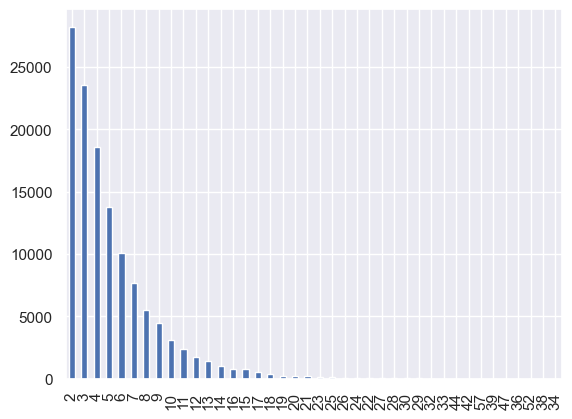

In [84]:
clicks.session_size.value_counts().plot(kind='bar')
plt.show()

### Nous pouvons à présent construire notre dataframe de rating

In [85]:
user_article_rating = clicks.groupby(by=['user_id', 'click_article_id']).agg(
    #'session_id': ['count', lambda x: list(x)],
    #'session_id': lambda x: list(x),
    #'session_id': 'count',    
    nb_readdings=('session_id', 'count'),
    is_readden=('session_id', lambda x: 1),
    mean_session_size=('session_size', 'mean'),
).reset_index()
user_article_rating

user_id  click_article_id  nb_readdings  is_readden  mean_session_size
0             3            234686             1           1                3.0
1             3            235665             1           1                3.0
2             3            235745             1           1                4.0
3             3            236065             1           1                2.0
4             3            236294             1           1                2.0
...         ...               ...           ...         ...                ...
123843   322666            313556             1           1               14.0
123844   322666            330990             1           1               14.0
123845   322666            331149             1           1               14.0
123846   322666            360547             1           1               14.0
123847   322666            361585             1           1               14.0

[123848 rows x 5 columns]

In [86]:
#user_article_rating['is_readden'].unique()

### Pour avoir notre colonne rating, il ne nous reste plus qu'à multiplier `nb_readdings` par `max_session_size` et normaliser les résultats (ou pas)

In [87]:
user_article_rating['rating_raw'] = user_article_rating['nb_readdings'] * user_article_rating['mean_session_size']

In [88]:
user_article_rating.describe()

user_id  click_article_id   nb_readdings  is_readden  \
count  123848.000000     123848.000000  123848.000000    123848.0   
mean    86433.737121     186415.545548       1.015899         1.0   
std     70926.898170     105989.545564       0.169203         0.0   
min         3.000000       1779.000000       1.000000         1.0   
25%     30129.000000      95976.750000       1.000000         1.0   
50%     66459.000000     187584.000000       1.000000         1.0   
75%    128551.000000     283276.000000       1.000000         1.0   
max    322666.000000     364043.000000      13.000000         1.0   

       mean_session_size     rating_raw  
count      123848.000000  123848.000000  
mean            5.265067       5.325883  
std             3.865463       3.920580  
min             2.000000       2.000000  
25%             3.000000       3.000000  
50%             4.000000       4.000000  
75%             7.000000       7.000000  
max            57.000000      57.000000

### Nous voyons ici que notre la range de notre rating va de 2 à 57

### Nous devrions pouvoir normaliser tout ça

In [89]:
user_article_rating['rating_norm'] = MinMaxScaler().fit_transform(np.array(user_article_rating['rating_raw']).reshape(-1,1))
user_article_rating.describe()

user_id  click_article_id   nb_readdings  is_readden  \
count  123848.000000     123848.000000  123848.000000    123848.0   
mean    86433.737121     186415.545548       1.015899         1.0   
std     70926.898170     105989.545564       0.169203         0.0   
min         3.000000       1779.000000       1.000000         1.0   
25%     30129.000000      95976.750000       1.000000         1.0   
50%     66459.000000     187584.000000       1.000000         1.0   
75%    128551.000000     283276.000000       1.000000         1.0   
max    322666.000000     364043.000000      13.000000         1.0   

       mean_session_size     rating_raw    rating_norm  
count      123848.000000  123848.000000  123848.000000  
mean            5.265067       5.325883       0.060471  
std             3.865463       3.920580       0.071283  
min             2.000000       2.000000       0.000000  
25%             3.000000       3.000000       0.018182  
50%             4.000000       4.000000       0.036364  
75%             7.000000       7.000000       0.090909  
max            57.000000      57.000000       1.000000

### Nous voyons ici que notre la plage de notre rating est bien passée de 0 à 1, nous pouvons multiplier cette valeur afin d'avoir un rating final proche de l'exemple de la librairie surprise que l'on peut voir ici : https://surprise.readthedocs.io/en/stable/getting_started.html#load-custom

In [111]:
user_article_rating['rating'] = user_article_rating['rating_norm'] * 5
user_article_rating.describe()

user_id  click_article_id   nb_readdings  is_readden  \
count  123848.000000     123848.000000  123848.000000    123848.0   
mean    86433.737121     186415.545548       1.015899         1.0   
std     70926.898170     105989.545564       0.169203         0.0   
min         3.000000       1779.000000       1.000000         1.0   
25%     30129.000000      95976.750000       1.000000         1.0   
50%     66459.000000     187584.000000       1.000000         1.0   
75%    128551.000000     283276.000000       1.000000         1.0   
max    322666.000000     364043.000000      13.000000         1.0   

       mean_session_size     rating_raw    rating_norm         rating  
count      123848.000000  123848.000000  123848.000000  123848.000000  
mean            5.265067       5.325883       0.060471       0.302353  
std             3.865463       3.920580       0.071283       0.356416  
min             2.000000       2.000000       0.000000       0.000000  
25%             3.000000       3.000000       0.018182       0.090909  
50%             4.000000       4.000000       0.036364       0.181818  
75%             7.000000       7.000000       0.090909       0.454545  
max            57.000000      57.000000       1.000000       5.000000

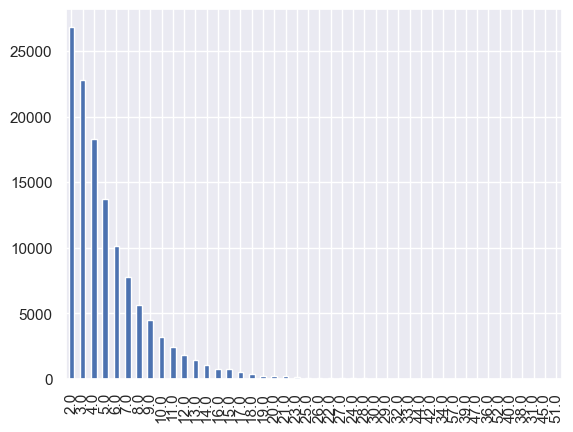

In [312]:
user_article_rating.rating_raw.value_counts().plot(kind='bar')
plt.show()

<a class="anchor" id="partie_4_2"></a><b><h2><font color=purple>4.2/ Modèles et entrainements</font></h2></b>

In [339]:
# Init des données

RS=42

# A reader is still needed but only the rating_scale param is requiered.
#reader = Reader(rating_scale=(0, 5))
reader = Reader(rating_scale=(2, 57))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(user_article_rating[["user_id", "click_article_id", "rating_raw"]], reader)

# Diviser les données en ensembles d'entraînement et de test
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=0.2)

In [340]:
#testset

### Prenons le modèle SVD et KNNBasic

In [341]:
# Use the famous SVD algorithm.
algo = SVD()


# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

algo2 = KNNBasic()

cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.0752  3.0616  3.1324  3.0656  3.0603  3.0790  0.0272  
MAE (testset)     2.1985  2.1979  2.2078  2.1914  2.1948  2.1981  0.0055  
Fit time          0.78    0.86    0.73    0.76    0.75    0.78    0.04    
Test time         0.10    0.10    0.11    0.11    0.11    0.11    0.01    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.0782  4.0469  3.9994  4.1048  4.1318  4.0722  0.0460

{'test_rmse': array([4.07824294, 4.04693258, 3.99943955, 4.10475451, 4.1317633 ]),
 'test_mae': array([2.70388691, 2.68632628, 2.66824202, 2.71152009, 2.69483798]),
 'fit_time': (1.5062239170074463,
  1.7971787452697754,
  1.6094999313354492,
  1.7386996746063232,
  1.5691609382629395),
 'test_time': (1.022310495376587,
  0.4261758327484131,
  0.4135298728942871,
  0.4851362705230713,
  0.4191732406616211)}

In [342]:
# Entraîner sur l'ensemble d'entraînement
algo.fit(trainset)
algo2.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [343]:
# Effectuer des prédictions sur l'ensemble de test
predictions = algo.test(testset)
# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 3.0510


3.0510495908511612

In [344]:
# Effectuer des prédictions sur l'ensemble de test
predictions2 = algo2.test(testset)
# Then compute RMSE
accuracy.rmse(predictions2)

RMSE: 4.0322


4.032182991236901

### L'algorithme SVD semble mieux apprendre que l'algo KNNBasic mais voyons les prédictions

<a class="anchor" id="partie_4_3"></a><b><h2><font color=purple>4.3/ Prédictions</font></h2></b>

### Obtenir les recommandations top-N pour 1 utilisateur

In [345]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [346]:
def get_top_n_for_user(top_n, uid):
    print(F"Recomandation for user : {uid}")
    for iid, est, true_r in top_n[uid]:
        print(F"article: {iid} (est. {est} - true. {true_r})")

### PRED SVD

In [347]:
predictions

[Prediction(uid=150456, iid=19645, r_ui=2.0, est=5.070138543315846, details={'was_impossible': False}),
 Prediction(uid=19879, iid=292622, r_ui=3.0, est=3.6724125244123753, details={'was_impossible': False}),
 Prediction(uid=11115, iid=71558, r_ui=2.0, est=4.255571998105733, details={'was_impossible': False}),
 Prediction(uid=7902, iid=360872, r_ui=3.0, est=4.451859828077115, details={'was_impossible': False}),
 Prediction(uid=232327, iid=7957, r_ui=2.0, est=4.660053592336177, details={'was_impossible': False}),
 Prediction(uid=168911, iid=337413, r_ui=3.0, est=3.990144157549173, details={'was_impossible': False}),
 Prediction(uid=10764, iid=66457, r_ui=5.0, est=3.610294553625465, details={'was_impossible': False}),
 Prediction(uid=82414, iid=137638, r_ui=8.0, est=5.767997538949565, details={'was_impossible': False}),
 Prediction(uid=80020, iid=157015, r_ui=3.0, est=4.286342129001282, details={'was_impossible': False}),
 Prediction(uid=43814, iid=324621, r_ui=3.0, est=4.152815472383193

In [348]:
top_n = get_top_n(predictions, n=5)
#top_n

In [349]:
get_top_n_for_user(top_n, 150456)

Recomandation for user : 150456
article: 19645 (est. 5.070138543315846 - true. 2.0)


In [350]:
get_top_n_for_user(top_n, 19879)

Recomandation for user : 19879
article: 288484 (est. 5.576826963152555 - true. 7.0)
article: 293327 (est. 3.917773798793964 - true. 2.0)
article: 292666 (est. 3.7468173886904914 - true. 4.0)
article: 292622 (est. 3.6724125244123753 - true. 3.0)
article: 293333 (est. 3.4015286801069404 - true. 7.0)


### PRED KNN

In [351]:
top_n2 = get_top_n(predictions2, n=5)
#top_n2

In [352]:
get_top_n_for_user(top_n2, 150456)

Recomandation for user : 150456
article: 19645 (est. 5.32400734774622 - true. 2.0)


In [353]:
get_top_n_for_user(top_n2, 19879)

Recomandation for user : 19879
article: 288484 (est. 5.999999999999999 - true. 7.0)
article: 292621 (est. 3.5555555555555554 - true. 4.0)
article: 293333 (est. 3.1862662906790633 - true. 7.0)
article: 293327 (est. 3.1005025125628145 - true. 2.0)
article: 292622 (est. 3.052036199095023 - true. 3.0)


[](#sommaire)